In [36]:
import numpy as np
import os
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from toolbox.utils import set_random_seed
import subprocess

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [4]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [5]:
# set random seed for reproducibility
set_random_seed(seed=42)

2025-12-03 15:32:37.237476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2025-12-03 15:32:37.237500: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


Seed set to 42


# Scaling control

see anshul_1on1_10312025.m4a, around 26'  
also: https://chatgpt.com/c/69307ade-8af0-832a-b470-c4a39e970309.  
also see my drawing: chip_vs_control.png

In [ ]:
base_dir = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble"
p_chip = f"{base_dir}/maya_coverage/all_reps.bw"
p_ctrl = f"{base_dir}/maya_coverage/inputc/inputc.bw"
chip_bed = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/all_reps.sorted.bed.gz"
ctrl_bed = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/input/input.bed.gz"
peaks = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.sorted"
genome = "/large_storage/goodarzilab/valehvpa/refs/hg38/hg38.chrom.sizes"
excluded_100b = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.100bp"
excluded_500b = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.500bp"
excluded_1kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.1000bp"
excluded_5kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.5000bp"
excluded_10kb = f"{base_dir}/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical.excluded.10000bp"

In [79]:
def run_for_L(L: int):
    # 1) generate more random regions than you need
    cmd = f"""
        bedtools random \
        -g {genome} \
        -l {L} \
        -n 20000 \
        > random_all.bed
    """
    subprocess.run(cmd, shell=True, check=True)

    # 2) remove ones that overlap your excluded regions
    cmd = f"""
        bedtools intersect \
        -v \
        -a random_all.bed \
        -b {peaks} \
        > random_no_excluded.bed
    """
    subprocess.run(cmd, shell=True, check=True)

    # 3) keep only the first 5000 that passed the filter
    if L == 5000:
        f = excluded_5kb
    elif L == 10000:
        f = excluded_10kb
    elif L == 1000:
        f = excluded_1kb
    elif L == 500:
        f = excluded_500b
    elif L == 100:
        f = excluded_100b
    else:
        raise ValueError("L not handled")
    cmd = f"""head -n 5000 random_no_excluded.bed > {f}"""
    subprocess.run(cmd, shell=True, check=True)

    # 4) delete intermediate files
    cmd = f"""
        rm random_all.bed random_no_excluded.bed
    """
    subprocess.run(cmd, shell=True, check=True)

run_for_L(100)
run_for_L(500)
run_for_L(1000)
run_for_L(5000)
run_for_L(10000)

In [80]:
df_100b = pd.read_csv(excluded_100b, sep="\t", header=None)
df_100b.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_500b = pd.read_csv(excluded_500b, sep="\t", header=None)
df_500b.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_1kb = pd.read_csv(excluded_1kb, sep="\t", header=None)
df_1kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_5kb = pd.read_csv(excluded_5kb, sep="\t", header=None)
df_5kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

df_10kb = pd.read_csv(excluded_10kb, sep="\t", header=None)
df_10kb.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)

In [85]:
len(df_100b), len(df_500b), len(df_1kb), len(df_5kb), len(df_10kb)

(4697, 4752, 4717, 4694, 4721)

Remove invalid chrombooses. My peaks file actually contains all valid chromosoms, let s just use that.

In [81]:
peaks_df = pd.read_csv(peaks, sep="\t", header=None)
peaks_df.rename(columns={0: "chrom", 1: "start", 2: "end"}, inplace=True)
valid_chroms = peaks_df["chrom"].unique().tolist()

In [82]:
df_100b = df_100b[df_100b["chrom"].isin(valid_chroms)]
df_500b = df_500b[df_500b["chrom"].isin(valid_chroms)]
df_1kb = df_1kb[df_1kb["chrom"].isin(valid_chroms)]
df_5kb = df_5kb[df_5kb["chrom"].isin(valid_chroms)]
df_10kb = df_10kb[df_10kb["chrom"].isin(valid_chroms)]

In [83]:
def run_for_L_2(L: int):
    import pyBigWig
    chip = pyBigWig.open(p_chip)
    control = pyBigWig.open(p_ctrl)
    if L == 5000:
        df = df_5kb
    elif L == 10000:
        df = df_10kb
    elif L == 1000:
        df = df_1kb
    elif L == 500:
        df = df_500b
    elif L == 100:
        df = df_100b
    else:
        raise ValueError("L not handled")
    vals = []
    vals_ctrl = []
    for _, r in df.iterrows():
        vals.append(np.nan_to_num(chip.values(
            r['chrom'], 
            r['start'],
            r['end'],
        )))
        vals_ctrl.append(np.nan_to_num(control.values(
            r['chrom'], 
            r['start'],
            r['end'],
        )))
    vals = np.array(vals)
    vals_ctrl = np.array(vals_ctrl)
    chip.close()
    control.close()
    return vals, vals_ctrl

vals_100b, vals_ctrl_100b = run_for_L_2(100)
vals_500b, vals_ctrl_500b = run_for_L_2(500)
vals_1k, vals_ctrl_1k = run_for_L_2(1000)
vals_5k, vals_ctrl_5k = run_for_L_2(5000)
vals_10k, vals_ctrl_10k = run_for_L_2(10000)

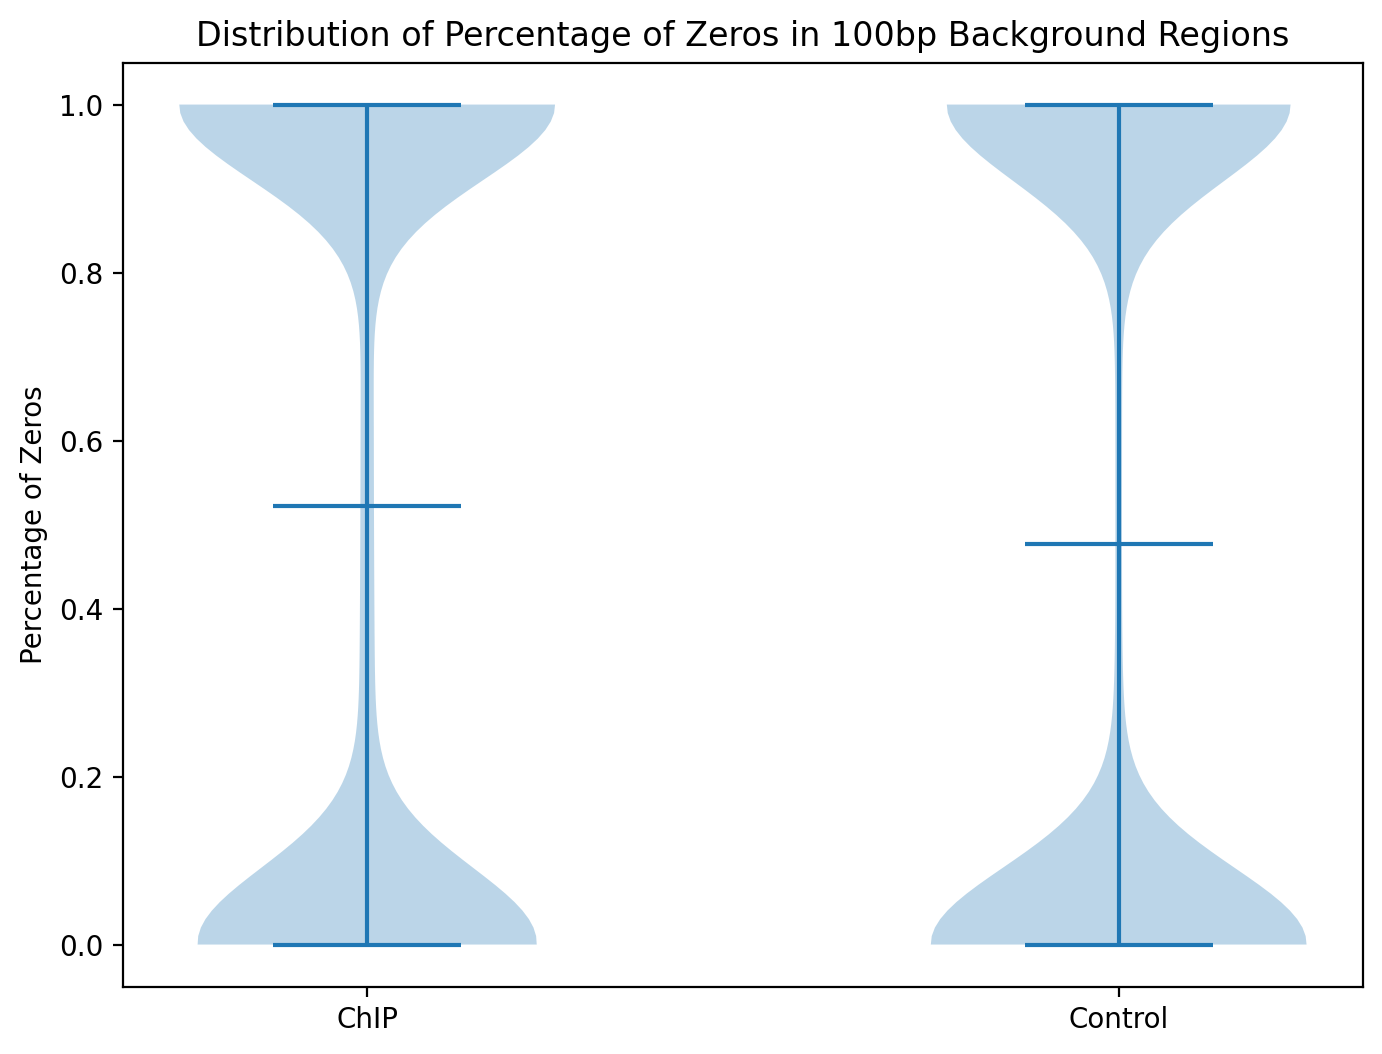

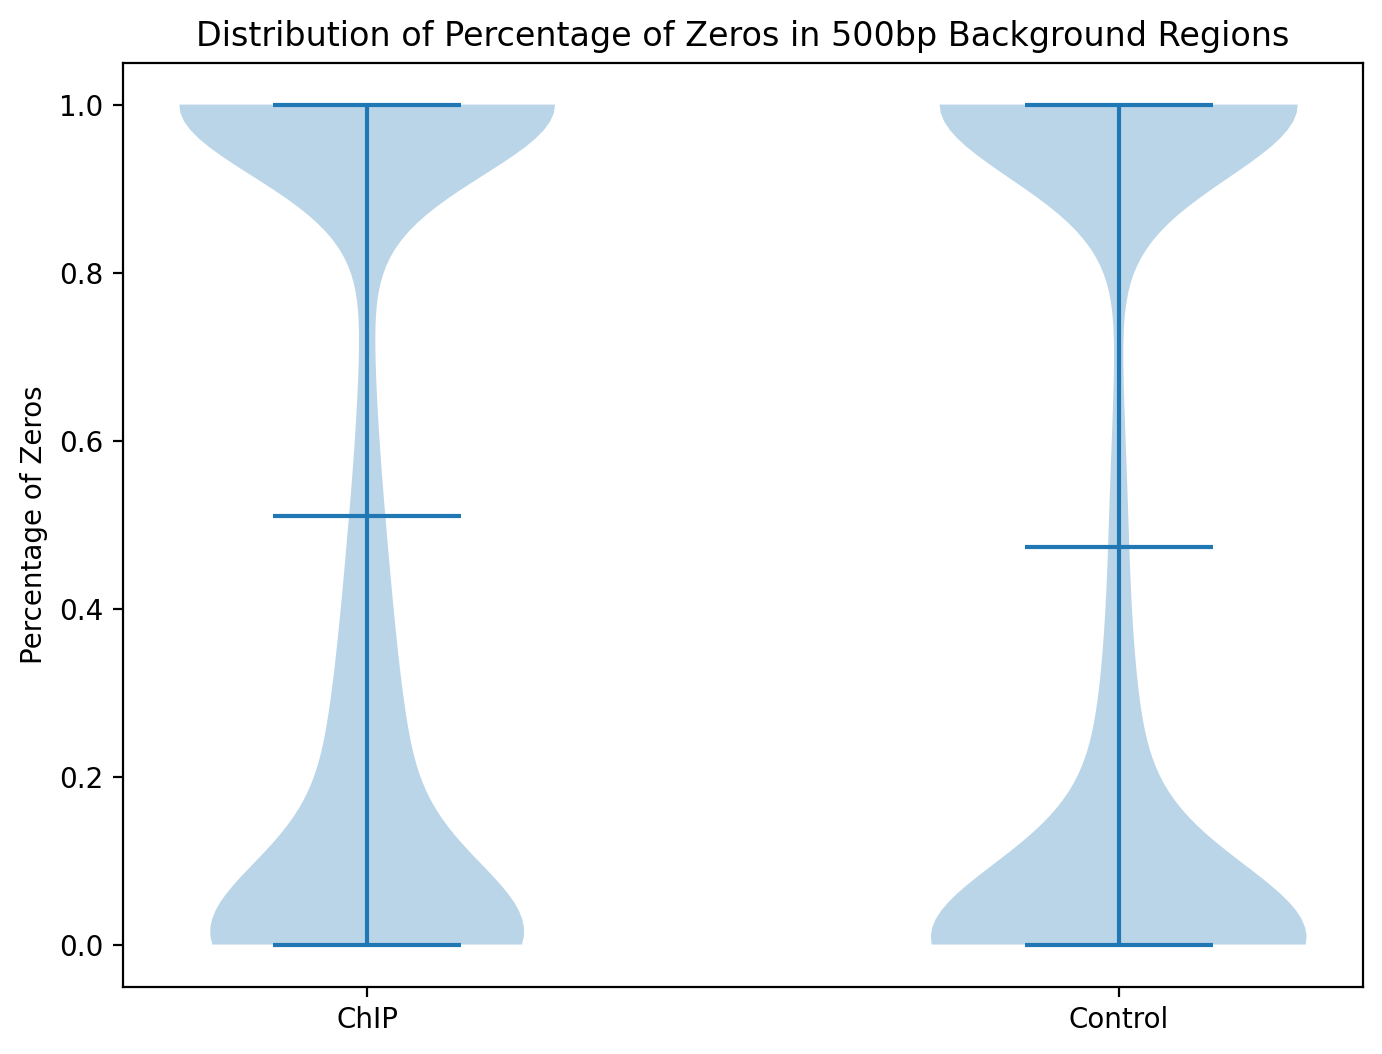

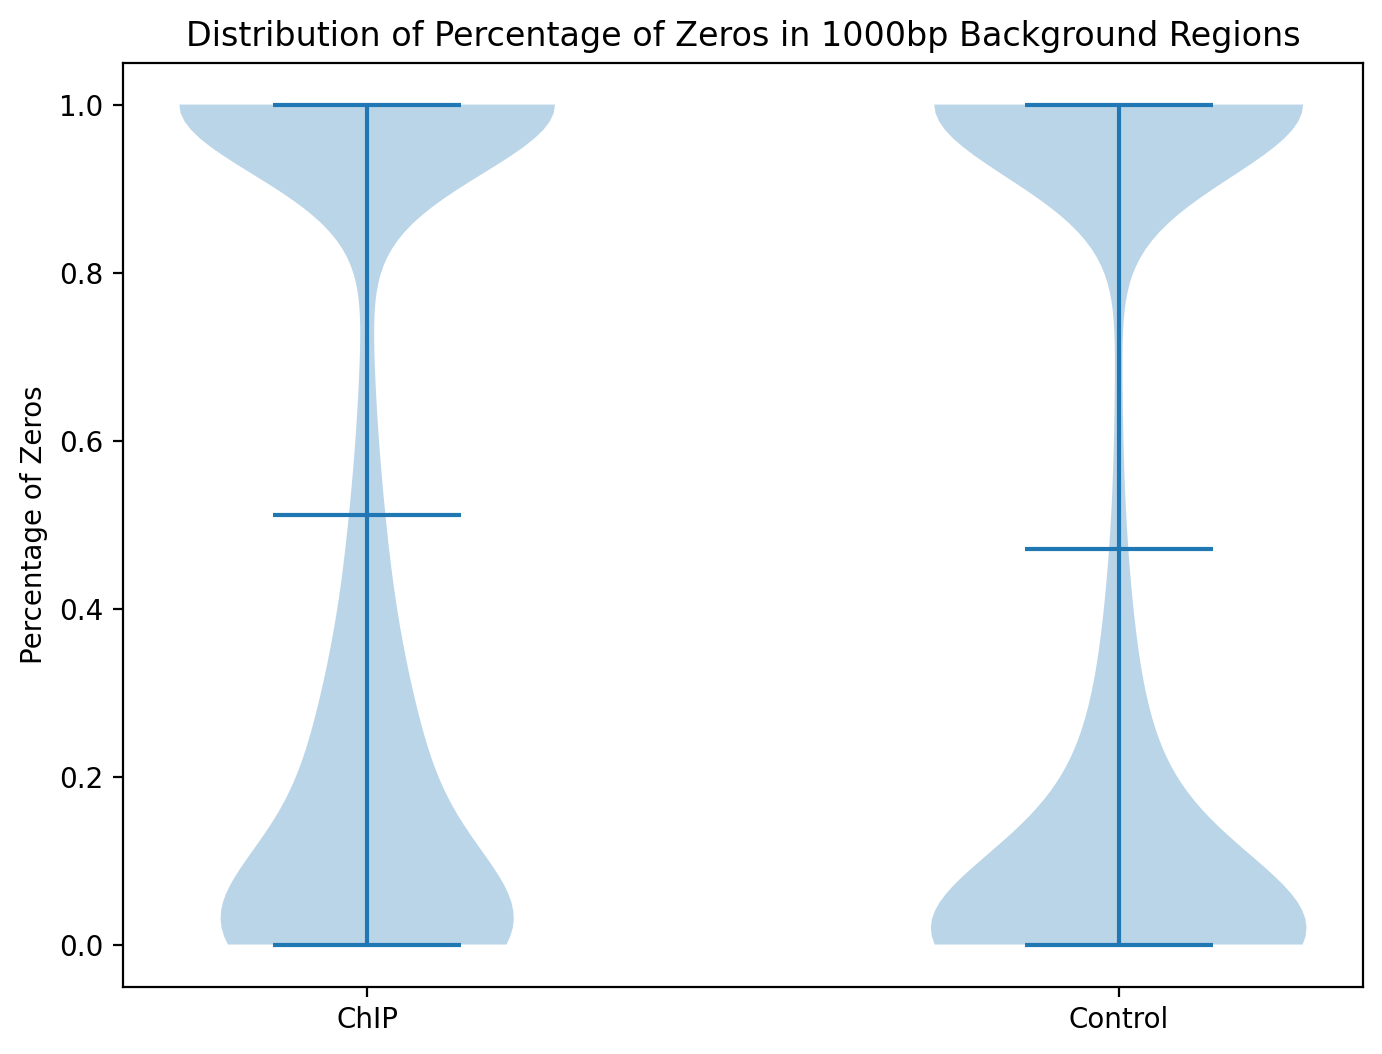

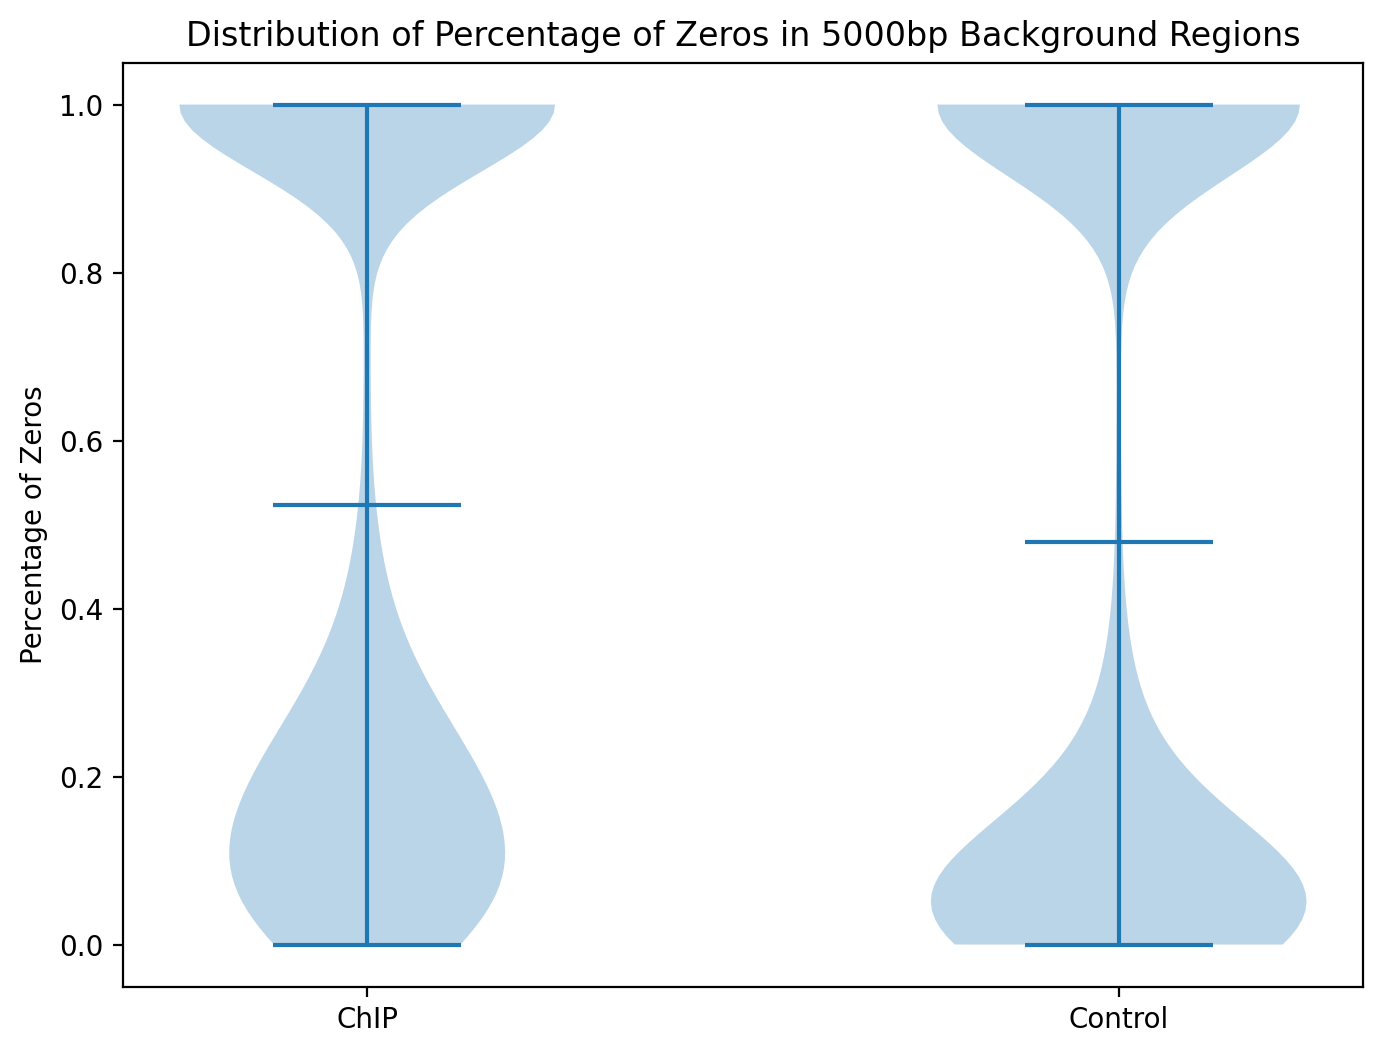

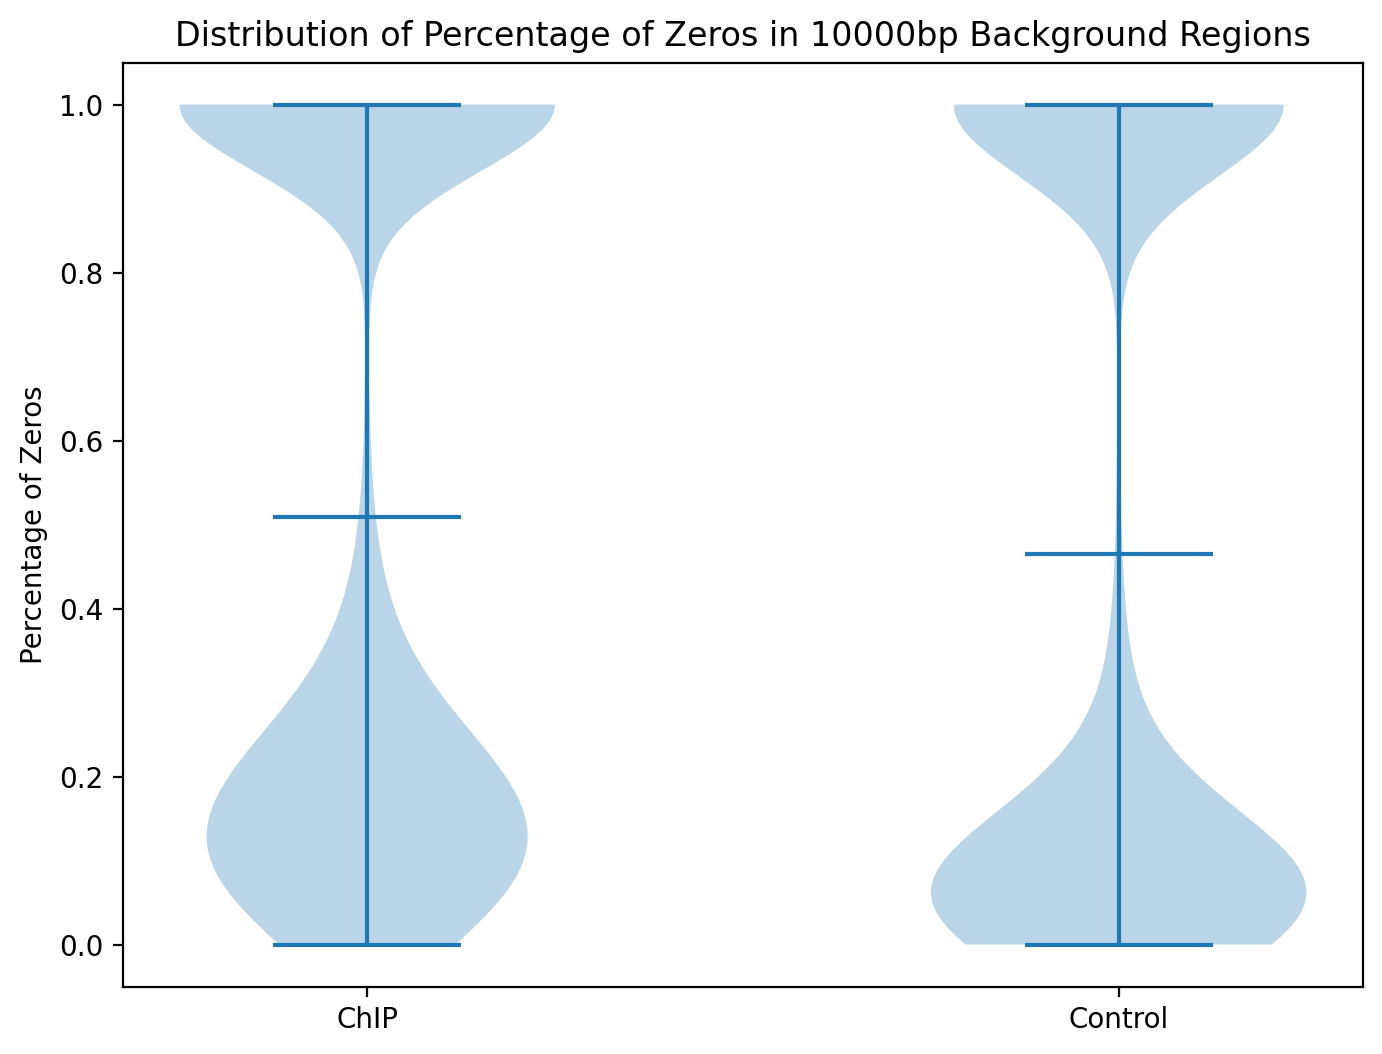

In [84]:
def run_for_L_3(L: int):
    if L == 5000:
        vals_ = vals_5k
        vals_ctrl_ = vals_ctrl_5k
    elif L == 10000:
        vals_ = vals_10k
        vals_ctrl_ = vals_ctrl_10k
    elif L == 1000:
        vals_ = vals_1k
        vals_ctrl_ = vals_ctrl_1k
    elif L == 500:
        vals_ = vals_500b
        vals_ctrl_ = vals_ctrl_500b
    elif L == 100:
        vals_ = vals_100b
        vals_ctrl_ = vals_ctrl_100b
    else:
        raise ValueError("L not handled")
    # percentage of 0s across dim 1
    pct_zeros = (vals_ == 0).sum(axis=1) / vals_.shape[1]
    pct_zeros_ctrl = (vals_ctrl_ == 0).sum(axis=1) / vals_ctrl_.shape[1]
    # plot violin plots of both arrays
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    data = [pct_zeros, pct_zeros_ctrl]
    plt.violinplot(data, positions=[1, 2], showmeans=True)
    plt.xticks([1, 2], ['ChIP', 'Control'])
    plt.ylabel('Percentage of Zeros')
    plt.title(f'Distribution of Percentage of Zeros in {L}bp Background Regions')
    plt.show()

run_for_L_3(100)
run_for_L_3(500)
run_for_L_3(1000)
run_for_L_3(5000)
run_for_L_3(10000)

So I dont 100% undersnad why these disributions are bimodal. The percentage of zeros in chip seems to be (ever so) slighly higher than in control in background regions, which is what I expected. Maybe percent zeros is not the right metric for sparsity... anyway, I just wanted to validate my earlier hypothesis (that backgroudn regions are likley more sarse in chip than in (unscaled) control, and likley the reverse for peak regions). Not sure the abbove actually shows that, mais passons.

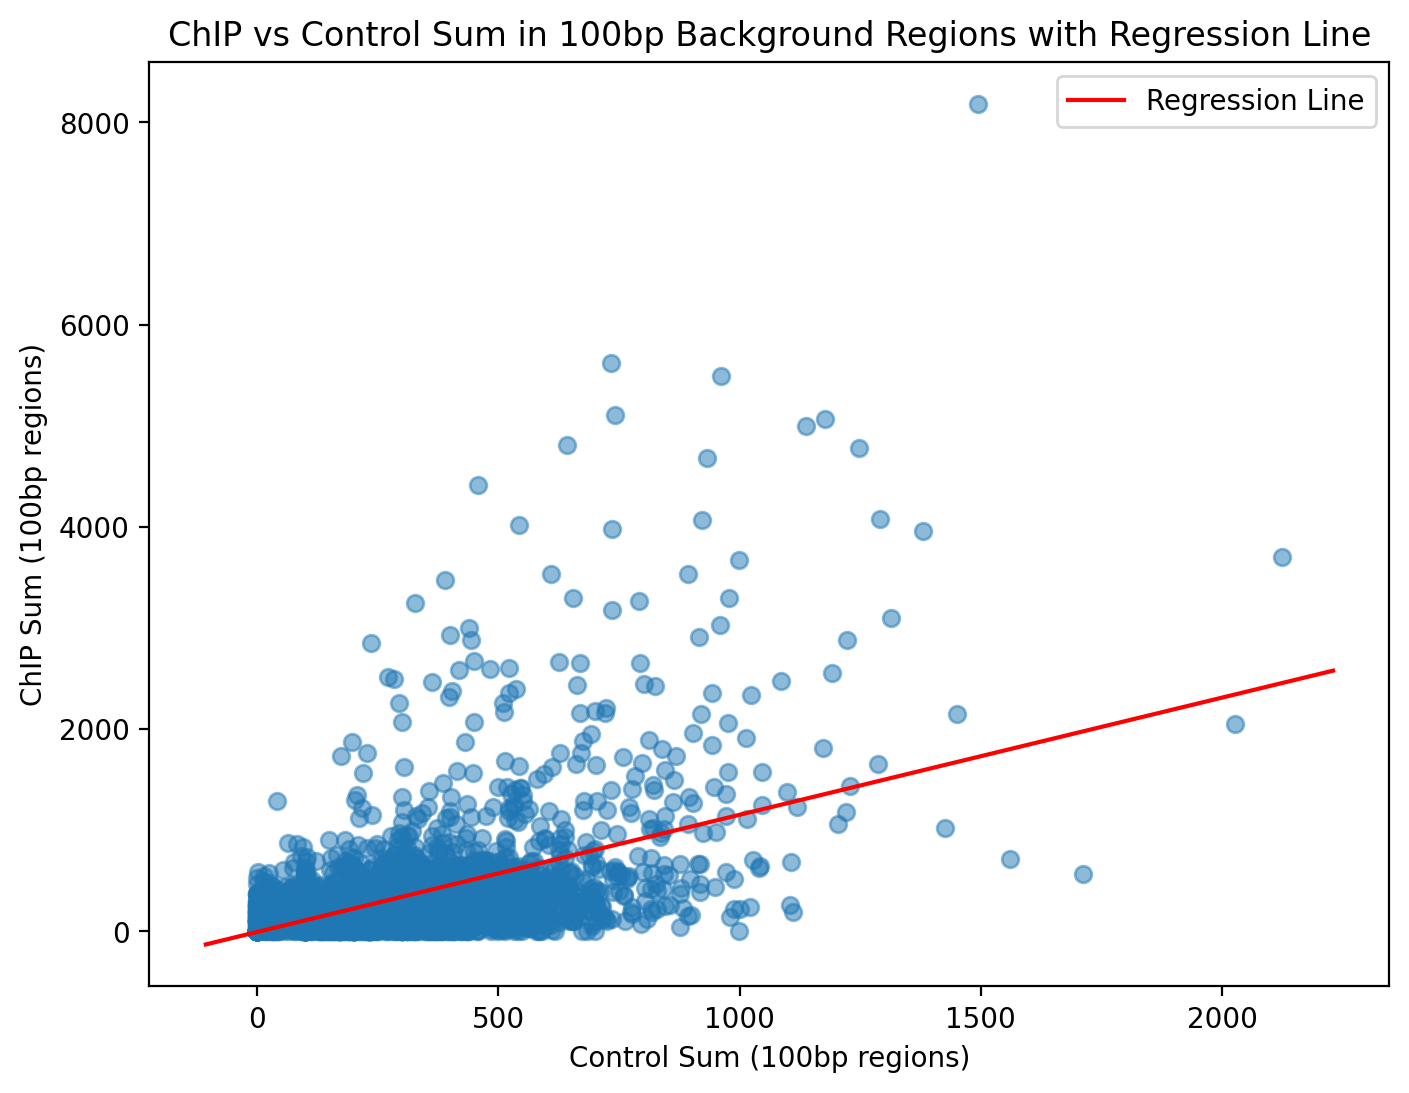

Scaling factor (slope of regression line): 1.1588244015817624
Intercept of regression line: -5.6068579521959805


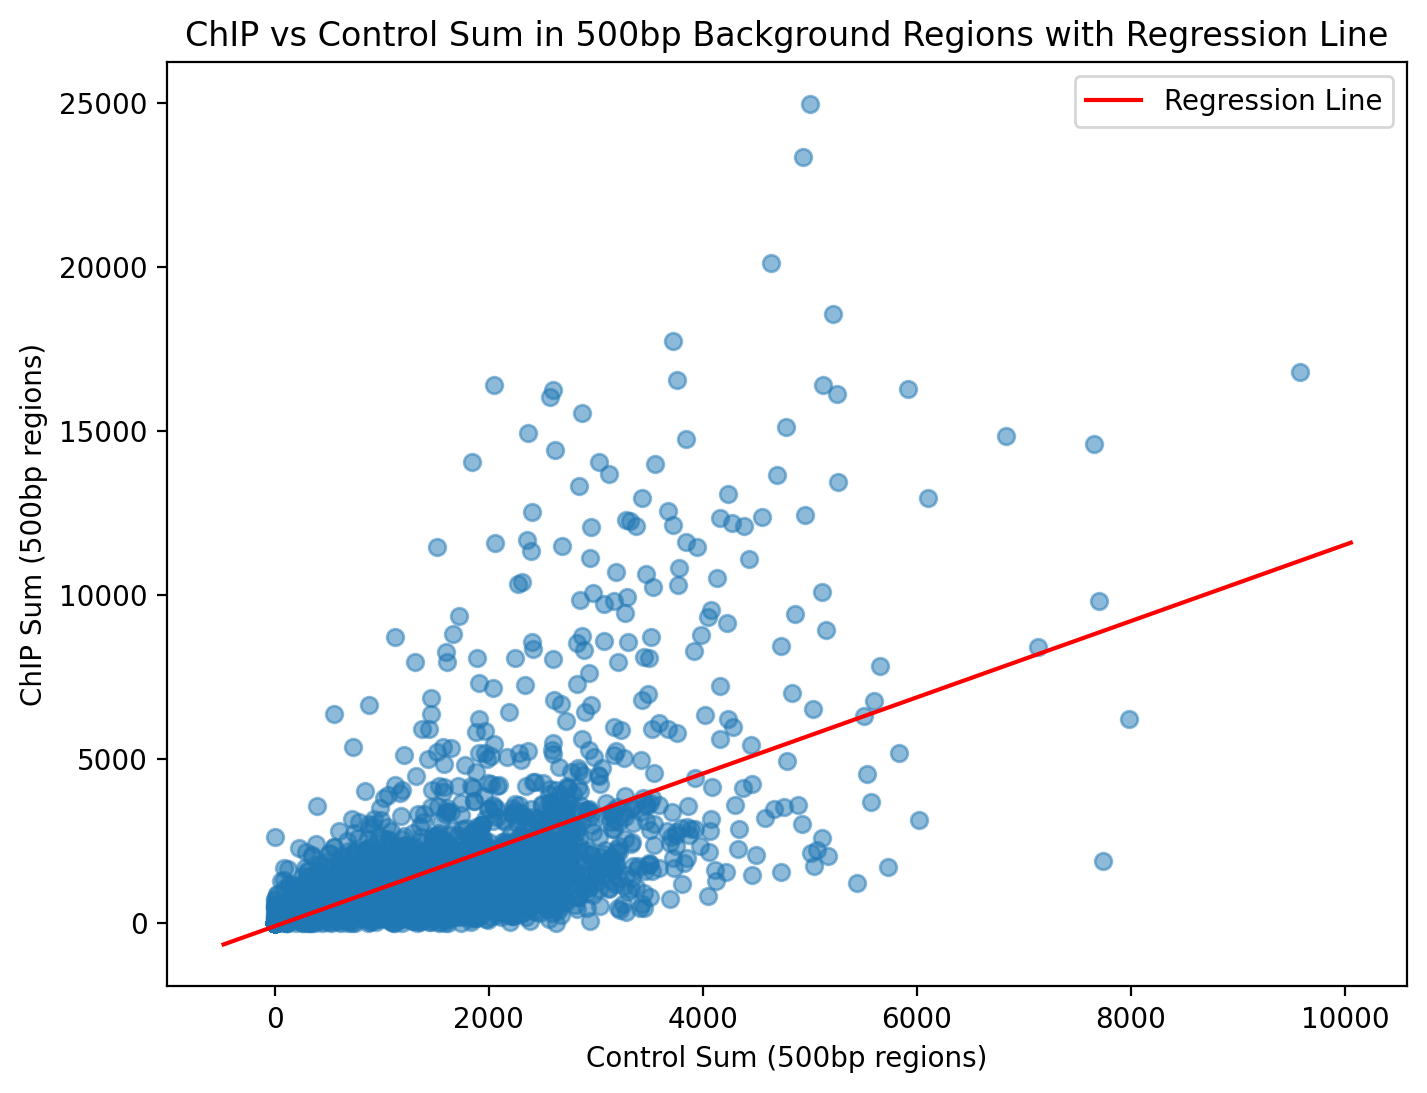

Scaling factor (slope of regression line): 1.162819068772218
Intercept of regression line: -94.92805786660062


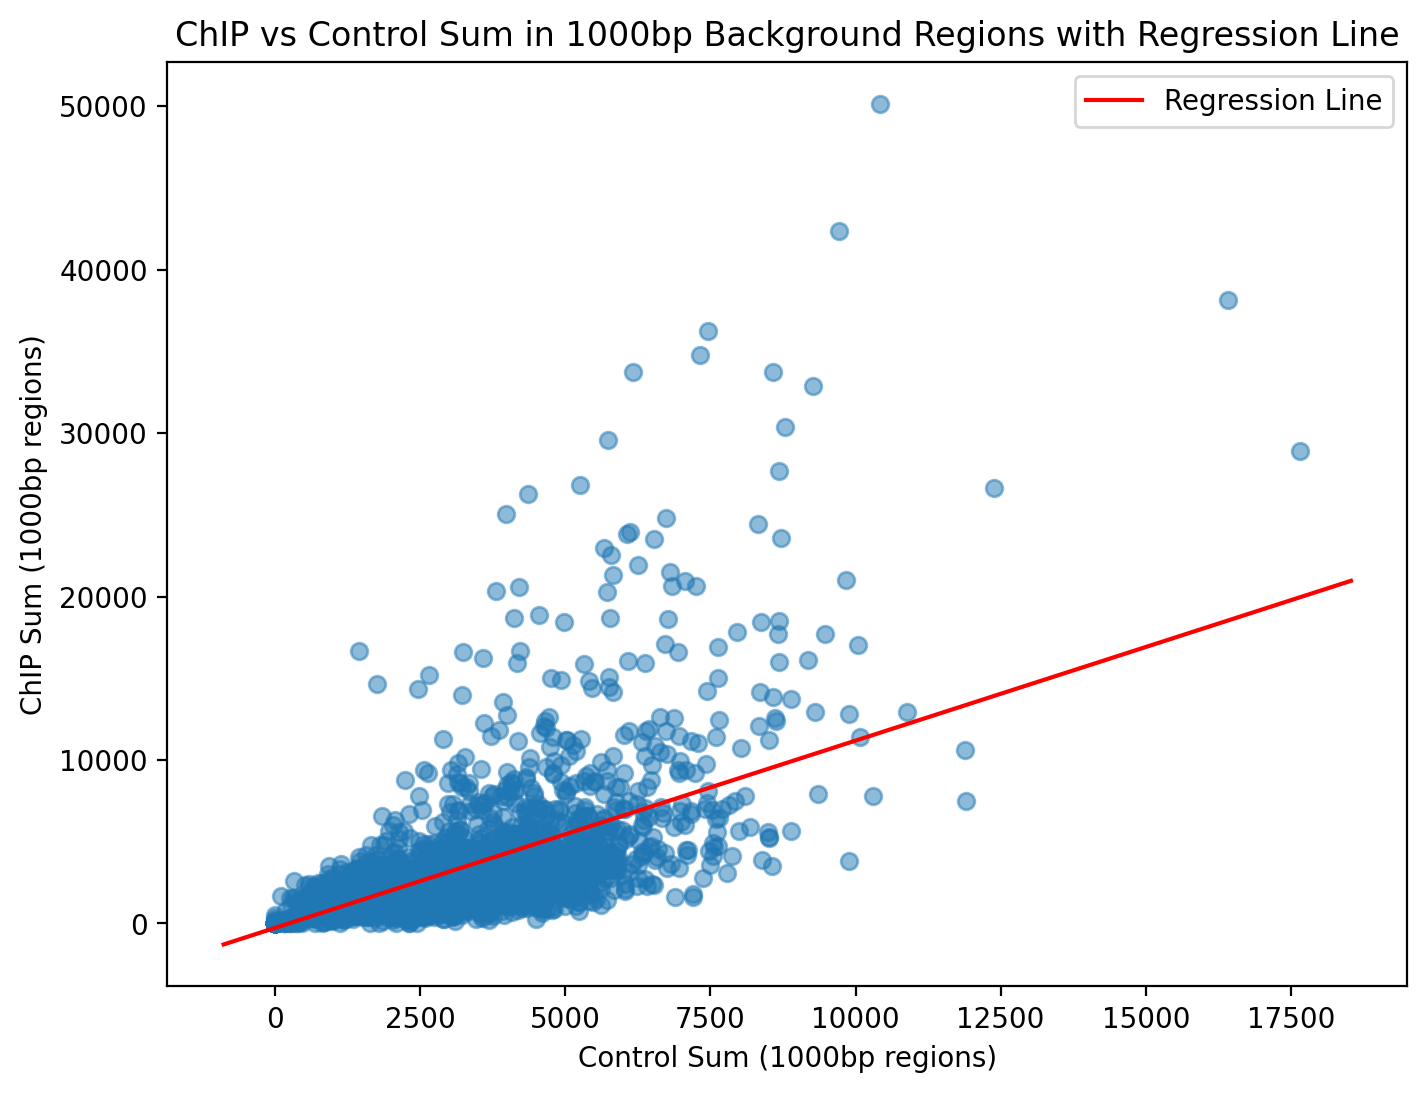

Scaling factor (slope of regression line): 1.1459757214096176
Intercept of regression line: -274.5742275311884


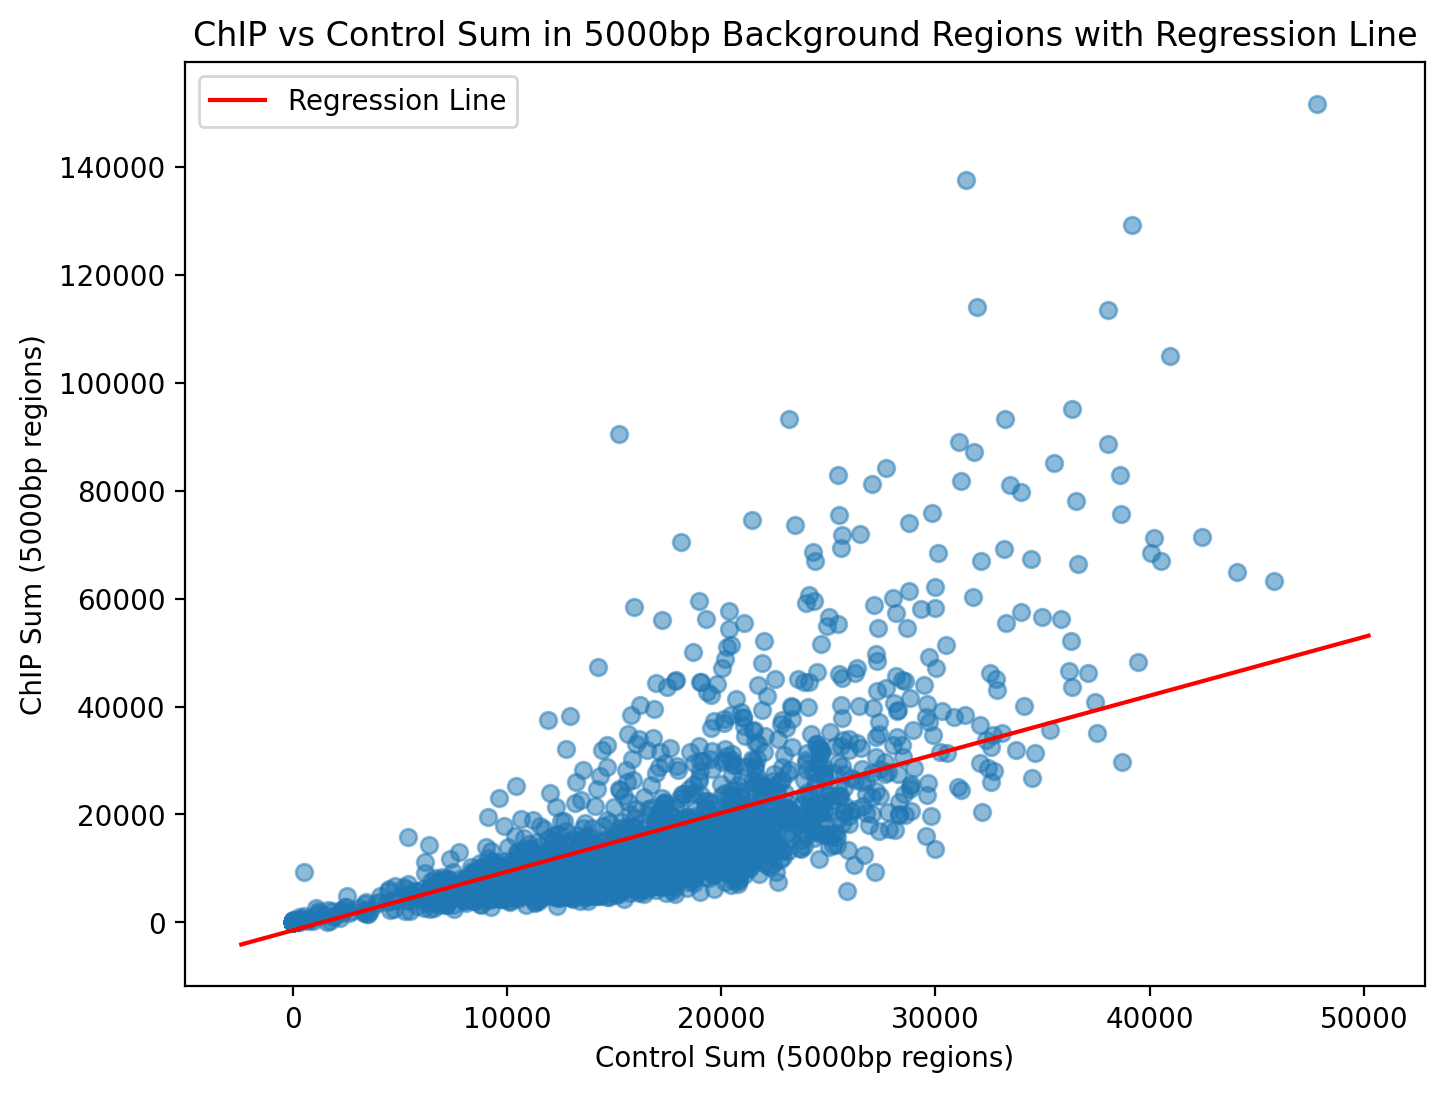

Scaling factor (slope of regression line): 1.0874460557004009
Intercept of regression line: -1480.0869628397595


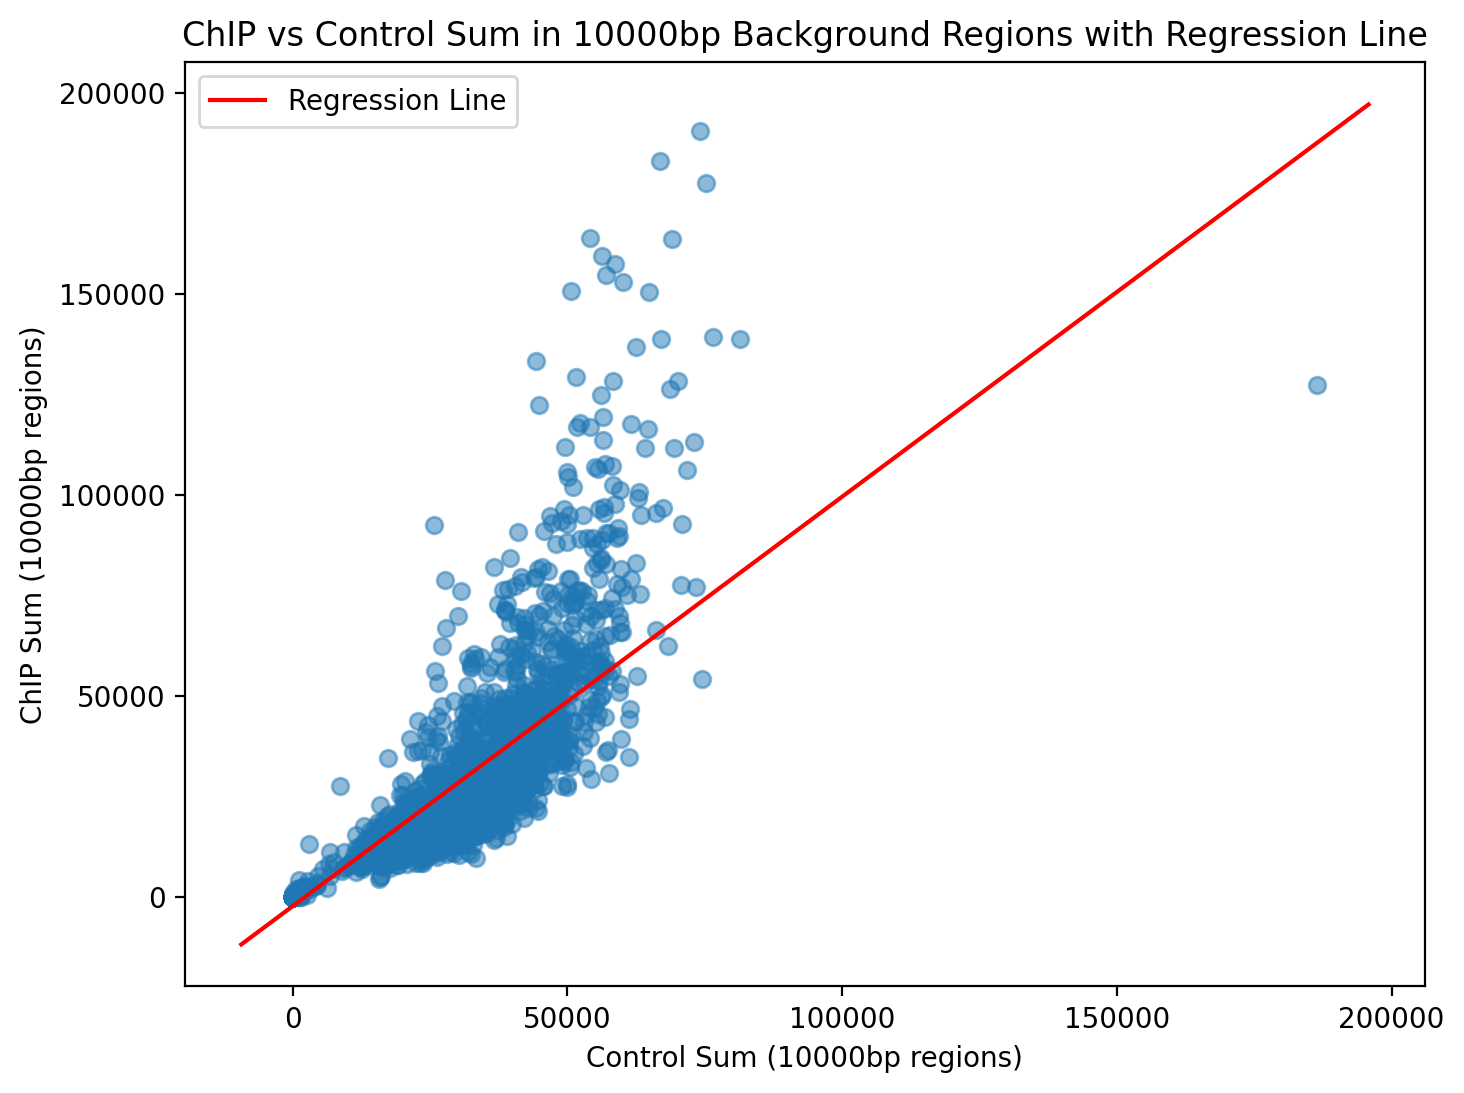

Scaling factor (slope of regression line): 1.0184537532308844
Intercept of regression line: -2369.6680409630007


In [88]:
def run_for_L_4(L: int):
    if L == 5000:
        vals_ = vals_5k
        vals_ctrl_ = vals_ctrl_5k
    elif L == 10000:
        vals_ = vals_10k
        vals_ctrl_ = vals_ctrl_10k
    elif L == 1000:
        vals_ = vals_1k
        vals_ctrl_ = vals_ctrl_1k
    elif L == 500:
        vals_ = vals_500b
        vals_ctrl_ = vals_ctrl_500b
    elif L == 100:
        vals_ = vals_100b
        vals_ctrl_ = vals_ctrl_100b
    else:
        raise ValueError("L not handled")
    
    # scatterplot of vals vs vals_ctrl for Lbp regions
    sum_ = vals_.sum(axis=1)
    sum_ctrl_ = vals_ctrl_.sum(axis=1)
    # linear regress chip on control to find a suitable scaling factor
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(sum_ctrl_.reshape(-1, 1), sum_)
    scaling_factor = model.coef_[0]
    # add the regression line to the scatterplot
    plt.figure(figsize=(8, 6))
    plt.scatter(sum_ctrl_, sum_, alpha=0.5)
    x_vals = np.array(plt.gca().get_xlim())
    y_vals = scaling_factor * x_vals + model.intercept_
    plt.plot(x_vals, y_vals, color='red', label='Regression Line')
    plt.xlabel(f'Control Sum ({L}bp regions)')
    plt.ylabel(f'ChIP Sum ({L}bp regions)')
    plt.title(f'ChIP vs Control Sum in {L}bp Background Regions with Regression Line')
    plt.legend()
    plt.show()
    print(f"Scaling factor (slope of regression line): {scaling_factor}")
    print("Intercept of regression line:", model.intercept_)

run_for_L_4(100)
run_for_L_4(500)
run_for_L_4(1000)
run_for_L_4(5000)
run_for_L_4(10000)

Wait all this time I was using bigwig files which contain fragemnet pileup-based coverage values. I guess what we wanted (at least for determining the scaling factor) is more about tag count (aka fragemnet count), so I guess we should use bed files for that (though I suppose one is some function of the other, as pileup is computed based on tags/fragments).

In [ ]:
# 25267228 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep1/rep1.bed
# 31150520 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep2/rep2.bed
# 26654427 /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep3/rep3.bed
# (hist6) GPU3694 :: ~/projects/toolbox ‹main*› » zcat /large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/maya_2013/align/rep4/rep4.bed.gz | wc -l 
# 76901233

In [89]:
25267228 + 31150520 + 26654427 + 76901233

159973408

In [90]:
34853714 / 159973408

0.21787192281357162

The scaling factor according to total read count is 5, per teh above ^

In [ ]:
def run_for_L_5(L: int):
    if L == 5000:
        df = df_5kb
    elif L == 10000:
        df = df_10kb
    elif L == 1000:
        df = df_1kb
    elif L == 500:
        df = df_500b
    elif L == 100:
        df = df_100b
    else:
        raise ValueError("L not handled")
    def count_reads_in_bed(bed_file: str, chrom: str, start: int, end: int) -> int:
        # tabix uses 0-based, half-open coordinates like BED
        cmd = f"tabix {bed_file} {chrom}:{start}-{end} | wc -l"
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True, check=True)
        return int(result.stdout.strip())
    vals = []
    vals_ctrl = []
    for _, r in df.iterrows():
        # read number of reads in chip and control bed files
        chip_reads = count_reads_in_bed(chip_bed, r['chrom'], r['start'], r['end'])
        ctrl_reads = count_reads_in_bed(ctrl_bed, r['chrom'], r['start'], r['end'])
        vals.append(chip_reads)
        vals_ctrl.append(ctrl_reads)
    vals = np.array(vals)
    vals_ctrl = np.array(vals_ctrl)
    return vals, vals_ctrl

# vals_100b, vals_ctrl_100b = run_for_L_5(100)
# vals_500b, vals_ctrl_500b = run_for_L_5(500)
# vals_1k, vals_ctrl_1k = run_for_L_5(1000)
vals_5k, vals_ctrl_5k = run_for_L_5(5000)
# vals_10k, vals_ctrl_10k = run_for_L_5(10000)

# write vals_5k and vals_ctrl_5k to npy files
# np.save("vals_100b.npy", vals_100b)
# np.save("vals_ctrl_100b.npy", vals_ctrl_100b)
# #
# np.save("vals_500b.npy", vals_500b)
# np.save("vals_ctrl_500b.npy", vals_ctrl_500b)
# #
# np.save("vals_1k.npy", vals_1k)
# np.save("vals_ctrl_1k.npy", vals_ctrl_1k)
#
np.save("vals_5k.npy", vals_5k)
np.save("vals_ctrl_5k.npy", vals_ctrl_5k)
#
# np.save("vals_10k.npy", vals_10k)
# np.save("vals_ctrl_10k.npy", vals_ctrl_10k)